In [5]:
# PNC

import pickle
import re
import numpy as np

basis_file = '/home/anton/Documents/Tulane/Research/PNC_Good/AngleBasisLong5.pkl'
demodir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/PNC/'

basis = pickle.load(open(basis_file, 'rb'))

thetas = []
jitter = []
age = []
fc = []
sex = []
race = []

demo = pickle.load(open(f'{demodir}/demographics.pkl', 'rb'))

for subtask in basis:
    m = re.search('([^-]+)-(.*)', subtask)
    sub = m.group(1)
    task = m.group(2)
    a = demo['age_at_cnb'][sub]
    age.append(a)
    s = demo['Sex'][sub] == 'M'
    r = demo['Race'][sub] == 'AA'
    sex.append(s)
    race.append(r)
    thetas.append(basis[subtask]['thetas'])
    jitter.append(basis[subtask]['jitter'])
    p = np.load(f'{demodir}/fc/{sub}_task-{task}_fc.npy')
    fc.append(p)
    
thetas = np.stack(thetas)
jitter = np.stack(jitter)
age = np.array(age)
fc = np.stack(fc)
sex = np.array(sex).astype('int')
race = np.array(race).astype('int')

print([a.shape for a in [thetas, jitter, age, sex, race, fc]])
print(np.mean(age))

[(3849, 5, 264), (3849, 5, 264), (3849,), (3849,), (3849,), (3849, 34716)]
14.398285268901013


In [2]:
# BSNIP

import pickle
import re
import numpy as np

basis_file = '/home/anton/Documents/Tulane/Research/BSNIP/AngleBasisLong5.pkl'
demodir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/BSNIP/'

basis = pickle.load(open(basis_file, 'rb'))

thetas = []
jitter = []
age = []
sex = []
race = []
sz = []
fc = []

demo = pickle.load(open(f'{demodir}/demographics.pkl', 'rb'))

for subtask in basis:
#     m = re.search('([^-]+)-(.*)', subtask)
    m = re.search('([^-]+)', subtask)
    sub = m.group(1)
#     task = m.group(2)
    a = demo['Age_cal'][sub]
    s = demo['sex'][sub] == 's1.0'
    r = demo['Race'][sub] == 'AA'
    z = demo['DXGROUP_2'][sub] == 'SZP'
    if demo['DXGROUP_2'][sub] not in ['SZP', 'NC']:
        continue
    age.append(a)
    sz.append(z)
    sex.append(s)
    race.append(r)
    thetas.append(basis[subtask]['thetas'])
    jitter.append(basis[subtask]['jitter'])
    p = np.load(f'{demodir}/fc/{sub}_task-unk_fc.npy')
    fc.append(p)
    
thetas = np.stack(thetas)
jitter = np.stack(jitter)
age = np.array(age).astype('int')
sex = np.array(sex).astype('int')
race = np.array(race).astype('int')
sz = np.array(sz).astype('int')
fc = np.stack(fc)

print([a.shape for a in [thetas, jitter, sex, race, sz, age, fc]])
print(np.mean(1-sex))
print(np.mean(1-race))
print(np.mean(1-sz))
print(np.mean(age))

[(441, 5, 264), (441, 5, 264), (441,), (441,), (441,), (441,), (441, 34716)]
0.4580498866213152
0.6439909297052154
0.5487528344671202
36.54875283446712


In [7]:
def rmse(yhat, y):
    if isinstance(yhat, np.ndarray) or isinstance(yhat, int):
        f = np.mean
    else:
        f = torch.mean
    return f((y-yhat)**2)**0.5

def tops(thetas, jitter):
    t0 = np.expand_dims(thetas, 2)
    t1 = np.expand_dims(thetas, 3)
    j0 = np.expand_dims(jitter, 2)
    j1 = np.expand_dims(jitter, 3)
    ps = np.cos(t0-t1)*(j0*j1)
    a,b = np.triu_indices(264, 1)
    ps = ps[:,:,a,b]
    return ps
    
ps = tops(thetas, jitter)
aps = np.mean(ps, axis=1)
res = fc-aps

print(ps.shape)
print(aps.shape)
print(res.shape)

(3849, 5, 34716)
(3849, 34716)
(3849, 34716)


In [8]:
from sklearn.decomposition import PCA, FactorAnalysis

# pca = PCA(n_components=3).fit(fc)
# fc_comp = pca.transform(fc)
# fc_low = pca.inverse_transform(fc_comp)

fa = FactorAnalysis(n_components=10).fit(fc)
fa_low = fa.transform(fc)@fa.components_
fa_res = fc-fa_low

print(fa_res.shape)
# print(fc_low.shape)

(3849, 34716)


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def fromnp(x):
    return torch.from_numpy(x).float().cuda()

def tonp(x):
    return x.detach().cpu().numpy()

fct = fromnp(fc)
fct = F.normalize(fct)
# dfc = torch.cdist(fct, fct)
dfc = fct@fct.T
dfc = tonp(dfc)

print(dfc.shape)

(3849, 3849)


In [766]:
ntr = 180
nt = 180

a = np.where(sz == 0)[0]
b = np.where(sz == 1)[0]

ia = np.random.permutation(a.shape[0])
ib = np.random.permutation(b.shape[0])

idcs = np.concatenate([a[ia[:90]], b[ib[:90]], a[ia[90:180]], b[ib[90:180]]])

ytr = sz[idcs[:ntr]]
yt = sz[idcs[ntr:ntr+nt]]

# xtr = aps[idcs[:ntr]]
# atr = age[idcs[:ntr]] > 30
# at = age[idcs[ntr:ntr+nt]] > 30
# sxtr = sex[idcs[:ntr]]
# sxt = sex[idcs[ntr:ntr+nt]]
# rtr = race[idcs[:ntr]]
# rt = race[idcs[ntr:ntr+nt]]
# sztr = sz[idcs[:ntr]]
# szt = sz[idcs[ntr:ntr+nt]]
# ytr = fromnp(sztr)
# xt = aps[idcs[ntr:ntr+nt]]
# yt = fromnp(szt)

# mu = np.mean(ytr)
# ytr -= mu
# yt -= mu

ytr = fromnp(ytr)
yt = fromnp(yt)

ntr = ytr.shape[0]
nt = yt.shape[0]

# xtr, ytr, xt, yt = [fromnp(a) for a in [xtr, ytr, xt, yt]]

n = torch.mean(ytr)
print(n)

E = dfc[idcs[ntr:ntr+nt]][:,idcs[:ntr]]
# lowidcs = np.argsort(E, axis=1)
# for i in range(lowidcs.shape[0]):
#     E[i,lowidcs[i,:-800]] = 0
E = fromnp(E)
# E = F.softmax(E, dim=1) 
E = F.normalize(E, p=1)
#fact = torch.sum(E, dim=1)
# # print(E@ytr/fact)
# # yhat = E@ytr/fact>n
yhat = (E@ytr)>n
yhat = tonp(yhat)
yt = tonp(yt)
print(roc_auc_score(yt, tonp(E@ytr)))
print(np.mean(yhat == yt))
print(yhat)
# print(np.mean(yhat[yt == 1] == 1))

# i = 0
# res = np.zeros((nt,16))
# truth = np.zeros(nt)

# for _sz in [sz, 1-sz]:
#     for _sex in [sex, 1-sex]:
#         for _race in [race, 1-race]:
#             for _age in [age > 30, age < 30]:
#                 sztr = _sz[idcs[:ntr]]
#                 szt = _sz[idcs[ntr:ntr+nt]]
#                 sxtr = _sex[idcs[:ntr]]
#                 sxt = _sex[idcs[ntr:ntr+nt]]
#                 rtr = _race[idcs[:ntr]]
#                 rt = _race[idcs[ntr:ntr+nt]]
#                 atr = _age[idcs[:ntr]]
#                 at = _age[idcs[ntr:ntr+nt]]
#                 ytr = sztr*sxtr*rtr*atr
#                 yt = szt*sxt*rt*at
#                 truth[yt == 1] = i
#                 ytr = fromnp(ytr)
#                 n = torch.mean(ytr)
#                 print(n)
#                 res[:,i] = tonp(E@ytr/n)
#                 i += 1
        
# print(truth)
# sum0 = np.sum(res[:,:8], axis=1)
# sum1 = np.sum(res[:,8:], axis=1)
# yhat = np.argmax(np.stack([sum0, sum1], axis=1), axis=1)
# yt = (truth > 8).astype('int')
# print(np.mean(yhat == yt))
# residcs = np.argsort(res, axis=1)
# print(np.mean(residcs[:,-1] == truth))
# print(np.mean(residcs[:,-2] == truth))
# print(np.mean(residcs[:,-3] == truth))
# print(np.mean(residcs[:,-4] == truth))
# print(np.mean(residcs[:,-5] == truth))
# print(np.mean(residcs[:,-6] == truth))
# print(np.mean(residcs[:,-7] == truth))
# print(np.mean(residcs[:,-8] == truth))
# # print(np.mean(residcs[:,2] == truth))
# # print(np.mean(residcs[:,1] == truth))
# # print(np.mean(residcs[:,0] == truth))

tensor(0.5000, device='cuda:0')
0.7230864197530865
0.6833333333333333
[False  True  True False False  True  True  True False False False False
 False False False False  True False  True False False False False False
  True False False  True False False False False False False False False
 False False  True False False  True False  True False False  True False
  True  True False False False  True False False False False False False
 False False False  True  True  True False False False False False False
  True False False  True False False False  True False False False False
 False  True  True  True False  True  True False False  True  True  True
  True  True  True False False  True  True  True False False  True  True
 False False False False False  True False  True False  True  True False
  True False  True  True  True False  True False  True False False  True
 False  True False  True  True  True  True  True  True  True  True  True
  True False  True  True  True False  True  True  True

In [288]:
race

array([1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,

In [45]:
from sklearn.model_selection import train_test_split
import torch.nn as nn

ntr = 2500
nt = 1000

idcs = np.random.permutation(fc.shape[0])

xtr = aps[idcs[:ntr]]
ytr = age[idcs[:ntr]]
xt = aps[idcs[ntr:ntr+nt]]
yt = age[idcs[ntr:ntr+nt]]

mu = np.mean(ytr)
ytr -= mu
yt -= mu

xtr, ytr, xt, yt = [fromnp(a) for a in [xtr, ytr, xt, yt]]

E = F.normalize(fromnp(dfc[idcs[:ntr]][:,idcs[:ntr]]))

class GIN(nn.Module):
    def __init__(self, nfeat):
        super(GIN, self).__init__()
        self.fc1a = nn.Linear(nfeat, 20, bias=False).float().cuda()
#         self.fc1b = nn.Linear(nfeat, 1, bias=False).float().cuda()
        self.fc2a = nn.Linear(20, 1).float().cuda()
#         self.fc2b = nn.Linear(20, 1).float().cuda()
        
    def forward(self, e, x):
        a = e@self.fc1a(x).squeeze()
        b = self.fc2a(a).squeeze()
        return b#+b
    
nepochs = 5000
pperiod = 100

gin = GIN(fc.shape[-1])
optim = torch.optim.Adam(gin.parameters(), lr=5e-5, weight_decay=1e-4)

for e in range(nepochs):
    optim.zero_grad()
    yhat = gin(E, xtr)
    loss = rmse(yhat, ytr)
    loss.backward()
    optim.step()
    if e == nepochs-1 or e % pperiod == 0:
        print(f'{e} {float(loss)}')
        
print('Done')

E = F.normalize(fromnp(dfc[idcs[:ntr+nt]][:,idcs[:ntr+nt]]))
with torch.no_grad():
    yhat = gin(E, torch.cat([xtr, xt]))
    print(rmse(yhat[ntr:], yt))
    print(rmse(0, tonp(yt)))

0 4.498091697692871
100 3.416490077972412
200 3.3382346630096436
300 3.6000139713287354
400 3.578662872314453
500 3.5580451488494873
600 3.5413122177124023
700 3.5269298553466797
800 3.513826847076416
900 3.5014724731445312
1000 3.489612340927124
1100 3.4781320095062256
1200 3.466970205307007
1300 3.4560983180999756
1400 3.445500612258911
1500 3.435164451599121
1600 3.425078868865967
1700 3.415239095687866
1800 3.405635356903076
1900 3.3962602615356445
2000 3.3871073722839355
2100 3.3781685829162598
2200 3.369433879852295
2300 3.3608949184417725
2400 3.352546215057373
2500 3.344376802444458
2600 3.3363804817199707
2700 3.328552722930908
2800 3.320882797241211
2900 3.313371419906616
3000 3.306009531021118
3100 3.298793077468872
3200 3.291717052459717
3300 3.284775733947754
3400 3.277965784072876
3500 3.2712836265563965
3600 3.264725923538208
3700 3.258286237716675
3800 3.251964569091797
3900 3.245757579803467
4000 3.2396600246429443
4100 3.233673334121704
4200 3.2277908325195312
4300 3.

In [26]:
dfc_fc = dfc

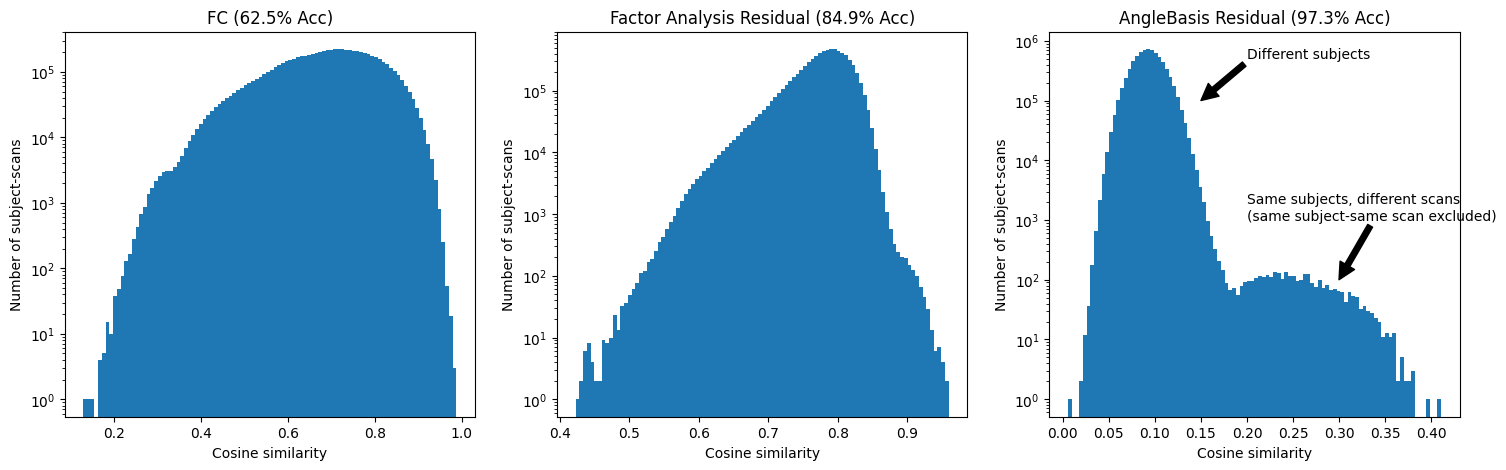

In [31]:
import matplotlib.pyplot as plt

a,b = np.triu_indices(dfc.shape[0],1)
dfcvec_fc = dfc_fc[a,b]
dfcvec_fa = dfc_fa[a,b]
dfcvec_ab = dfc_ab[a,b]

fig, ax = plt.subplots(1,3,figsize=(18,5))

ax[0].hist(dfcvec_fc, bins=100, log=True)
ax[0].set_ylabel('Number of subject-scans')
ax[0].set_xlabel('Cosine similarity')
ax[0].set_title('FC (62.5% Acc)')

ax[1].hist(dfcvec_fa, bins=100, log=True)
ax[1].set_ylabel('Number of subject-scans')
ax[1].set_xlabel('Cosine similarity')
ax[1].set_title('Factor Analysis Residual (84.9% Acc)')

ax[2].hist(dfcvec_ab, bins=100, log=True)
ax[2].set_ylabel('Number of subject-scans')
ax[2].set_xlabel('Cosine similarity')
ax[2].set_title('AngleBasis Residual (97.3% Acc)')
ax[2].annotate("Different subjects",xy=(0.15,1e5),xytext=(0.2,5e5),arrowprops=dict(facecolor='black'))
ax[2].annotate("Same subjects, different scans\n(same subject-same scan excluded)",
             xy=(0.3,1e2),xytext=(0.2,1e3),arrowprops=dict(facecolor='black'))
fig.show()
fig.savefig('/home/anton/Documents/Tulane/Research/Work/AngleBasis/Fingerprinting.pdf')